In [171]:
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric



from sklearn.datasets import make_moons

from tqdm import tqdm

In [172]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
# inpDir = Path('..') / '..' / 'input'
# # outDir = '../output'
# outDir = Path('..') / 'output'


RANDOM_STATE = 24 
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

TEST_SIZE  = 0.2 # Size of test data

NOISE = 0.2
N_SAMPLE = 1000
EPOCHS = 201
ALPHA = 0.001


# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')


# numpy random set
rng = np.random.default_rng(seed=RANDOM_STATE)

In [173]:
X, y = make_moons(n_samples=N_SAMPLE, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

In [174]:
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0]))

In [175]:
X.shape

(1000, 2)

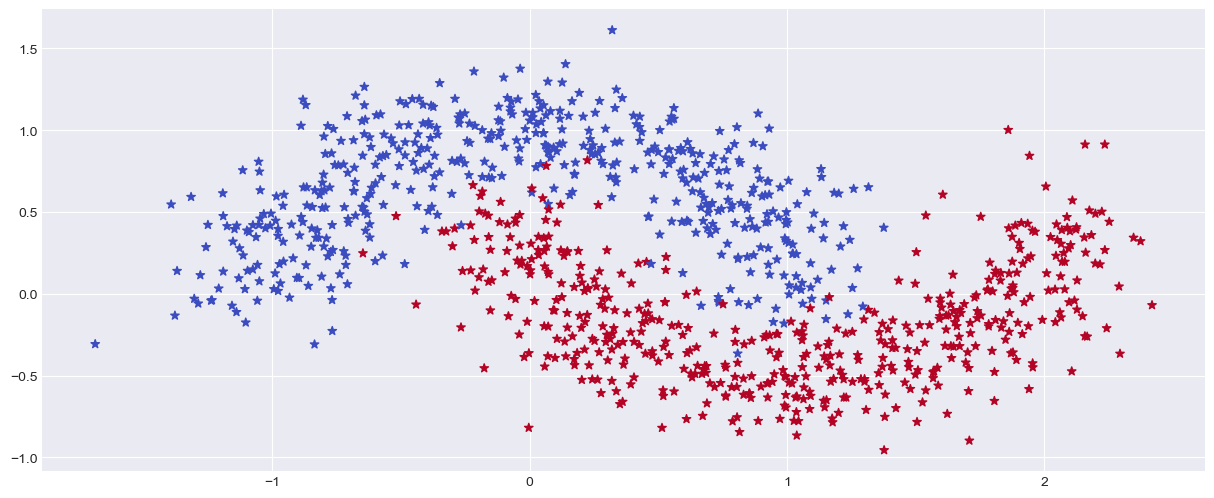

In [176]:
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker='*', cmap=CMAP)

In [177]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [178]:
data_train, data_test = data_df.to_numpy()[:900], data_df.to_numpy()[900:]
data_train.shape, data_test.shape

((900, 3), (100, 3))

In [179]:
def predict(row, weights):
    z = weights[0]
    for i in range(len(row) - 1):
        z +=  weights[i+1] * row[i]    # aggregation : w*x + b

    return 1 if z >= 0 else 0  # simplest activation function

In [180]:
# checking if predict function works
weights = np.array([0.1, 2.0, 1.0])
predict(data_df.loc[0].to_numpy(), weights=weights)

1

#### The method below is Stochastic Gradient Descent.

In [181]:

def train_weights(train, alpha, n_epoch):

    error = [] # to track error
    weights = rng.random(train.shape[1])  # initialize weights at random
    m = train.shape[0] # number of rows

    for epoch in tqdm(range(n_epoch)):  # looping for number of epochs
        sum_error = 0   # to collect error for this epoch 
        for row in train:  # looping through all rows in one epoch
            prediction = predict(row, weights)  # getting prediction for the row   -------> FORWARD PROPAGATION

            # ---------> BACKPROPAGATION STARTS <---------

            dz = prediction - row[-1]  # calculating slope of loss wrt z = (a - y)            
            sum_error += (prediction - row[-1])**2  # adding errors for each row - using mean squared error as loss

            weights[0] = weights[0] - alpha * dz   # updating bias
            for i in range(len(row) - 1):
                weights[i+1] = weights[i+1] - alpha * dz * row[i]    # updating weights       

            # ---------> BACKPROPAGATION ENDS <-----------

        error.append(sum_error/m)  # average error
        
    return error, weights


The code that we wrote is implementation of a perceptron.

In [182]:

EPOCHS = 200
error, weights = train_weights(train=data_train, alpha=ALPHA, n_epoch=EPOCHS)
weights

100%|██████████| 200/200 [00:00<00:00, 280.65it/s]


array([-0.00073116,  0.00252746, -0.00400164])

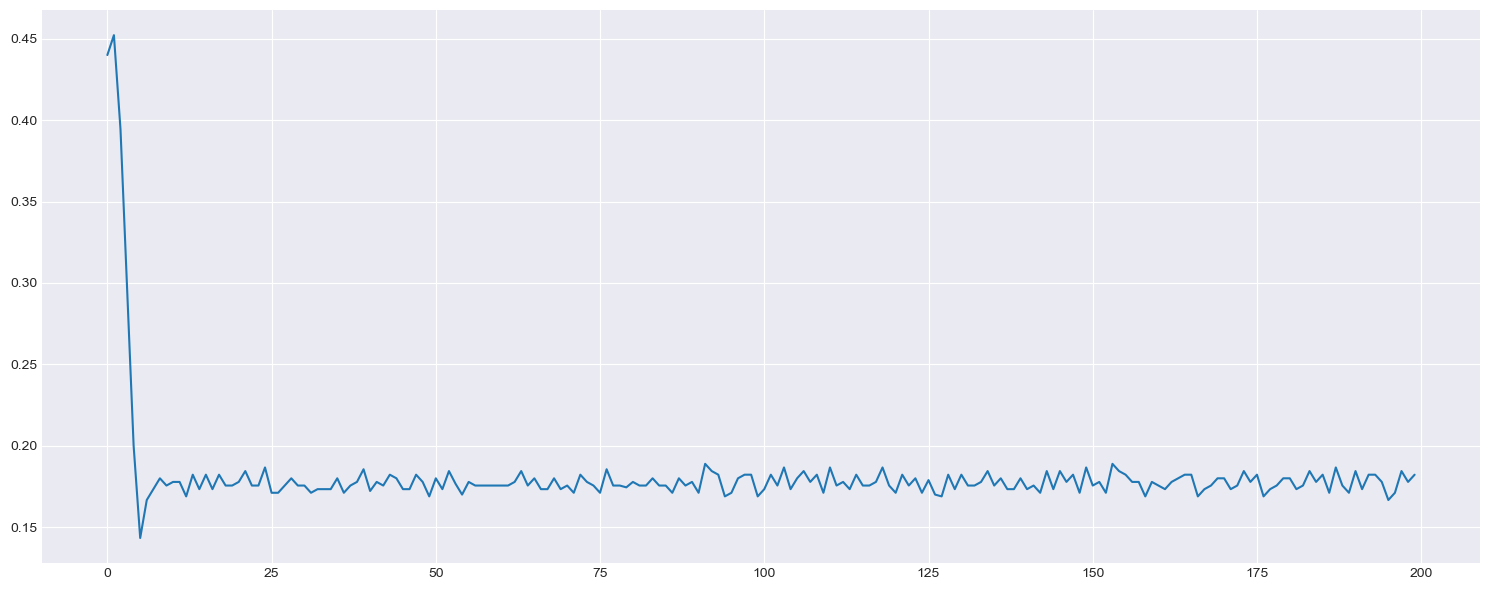

In [183]:
# average error per epoch plot
gig, ax = plt.subplots()
ax.plot(error)
plt.tight_layout()
plt.show()

The error can increase in the initial few epochs ---> initial warmup. Ignore that

Plotting decision boundary

In [194]:
def plot_decision_boundary():
    fig, ax = plt.subplots()

    dm = 0.01   # cells that we want to fill with colors
    margin = 10*dm # margin
    x_min, x_max = X[:, 0].min() + margin, X[:, 0].max() - margin # x axis values
    y_min, y_max = X[:, 1].min() + margin, X[:, 1].max() - margin # y axis values

    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm), 
                        np.arange(y_min, y_max, dm))    # meshgrid gives 2D data, we are finding all combinations of x and y within the min, max range

    X_plot = np.c_[xx.ravel(), yy.ravel()]  # convert xx and yy into 2D matrix

    X_plot = np.hstack((X_plot, np.ones((X_plot.shape[0], 1))))  # adding a third column with any values just to match 
                                                                    # the shape of our original data according to which we wrote earlier code

    y_pred = []

    for row in (X_plot):    # looping over meshgrid points
        y_p = predict(row, weights)   # predicting over each point
        y_pred.append(y_p)

    #  ; to hide output

    Z = np.array(y_pred).reshape(xx.shape)  # y_pred to xx shape
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=CMAP)   # contourf for filled contour
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors='k', cmap=plt.cm.bwr)  # scatter plot to overplot original data points
    plt.show()

The contour here is the straight-ish line. 

In [185]:
X_plot.shape, len(y_pred)

((92667, 3), 92667)

In [186]:
xx.shape, yy.shape, Z.shape

((237, 391), (237, 391), (237, 391))

## SIGMOID

In [187]:
def fn_sigmoid(z: np.ndarray) -> float:
     return 1 / (1 + np.exp(-z))

In [188]:
sm = fn_sigmoid(np.asarray([-np.inf, -1,0, np.inf]))
sm

array([0.        , 0.26894142, 0.5       , 1.        ])

In [189]:
def predict(row, weights):
    z = weights[0]
    for i in range(len(row) - 1):
        z +=  weights[i+1] * row[i]    # aggregation : w*x + b

    return fn_sigmoid(z)

In [ ]:
def train_weights(train, alpha, n_epoch):

    error = [] # to track error
    weights = rng.random(train.shape[1])  # initialize weights at random
    m = train.shape[0] # number of rows

    for epoch in tqdm(range(n_epoch)):  # looping for number of epochs
        sum_error = 0   # to collect error for this epoch 
        for row in train:  # looping through all rows in one epoch
            a = predict(row, weights)  # getting prediction for the row   -------> FORWARD PROPAGATION

            # ---------> BACKPROPAGATION STARTS <---------

            dz = a - row[-1]  # calculating slope of loss wrt z = (a - y)     
            err =  - row[-1] * np.log(a) - (1- row[-1])*np.log(1-a)       # Binary error
            sum_error +=  err  # adding errors for each row - using mean squared error as loss

            weights[0] = weights[0] - alpha * dz   # updating bias
            for i in range(len(row) - 1):
                weights[i+1] = weights[i+1] - alpha * dz * row[i]    # updating weights       

            # ---------> BACKPROPAGATION ENDS <-----------

        error.append(sum_error/m)  # average error
        
    return error, weights


In [191]:

EPOCHS = 200
error, weights = train_weights(train=data_train, alpha=ALPHA, n_epoch=EPOCHS)
weights

100%|██████████| 200/200 [00:01<00:00, 117.10it/s]


array([ 0.42337501,  1.17645425, -4.28565901])

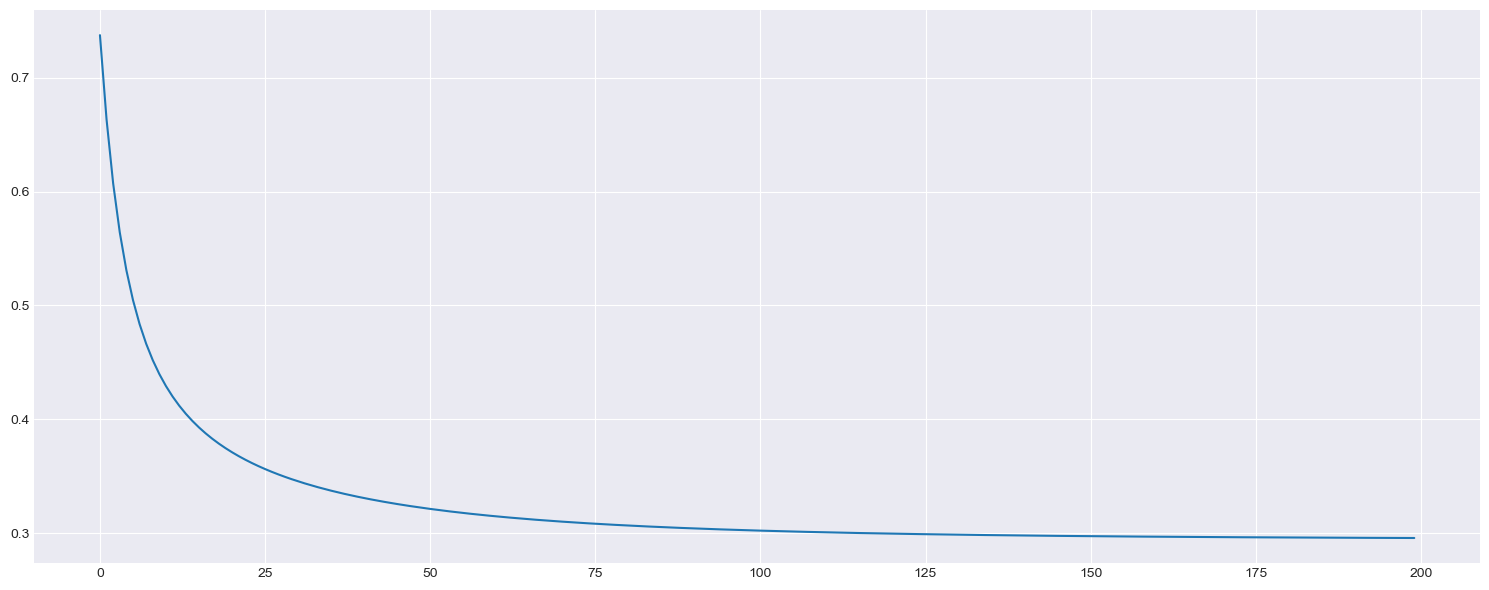

In [192]:
# average error per epoch plot
fig, ax = plt.subplots()
ax.plot(error)
plt.tight_layout()
plt.show()

In [197]:
def plot_decision_boundary():
    fig, ax = plt.subplots()

    dm = 0.01   # cells that we want to fill with colors
    margin = 10*dm # margin
    x_min, x_max = X[:, 0].min() + margin, X[:, 0].max() - margin # x axis values
    y_min, y_max = X[:, 1].min() + margin, X[:, 1].max() - margin # y axis values

    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm), 
                        np.arange(y_min, y_max, dm))    # meshgrid gives 2D data, we are finding all combinations of x and y within the min, max range

    X_plot = np.c_[xx.ravel(), yy.ravel()]  # convert xx and yy into 2D matrix

    X_plot = np.hstack((X_plot, np.ones((X_plot.shape[0], 1))))  # adding a third column with any values just to match 
                                                                    # the shape of our original data according to which we wrote earlier code

    y_pred = []

    for row in (X_plot):    # looping over meshgrid points
        # Make pred
        a = predict(row,weights)

        y_p = 0  

        if a>= 0.5: y_p=1

        y_pred.append(y_p)

    #  ; to hide output

    Z = np.array(y_pred).reshape(xx.shape)  # y_pred to xx shape
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=CMAP)   # contourf for filled contour
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors='k', cmap=plt.cm.bwr)  # scatter plot to overplot original data points
    plt.show()

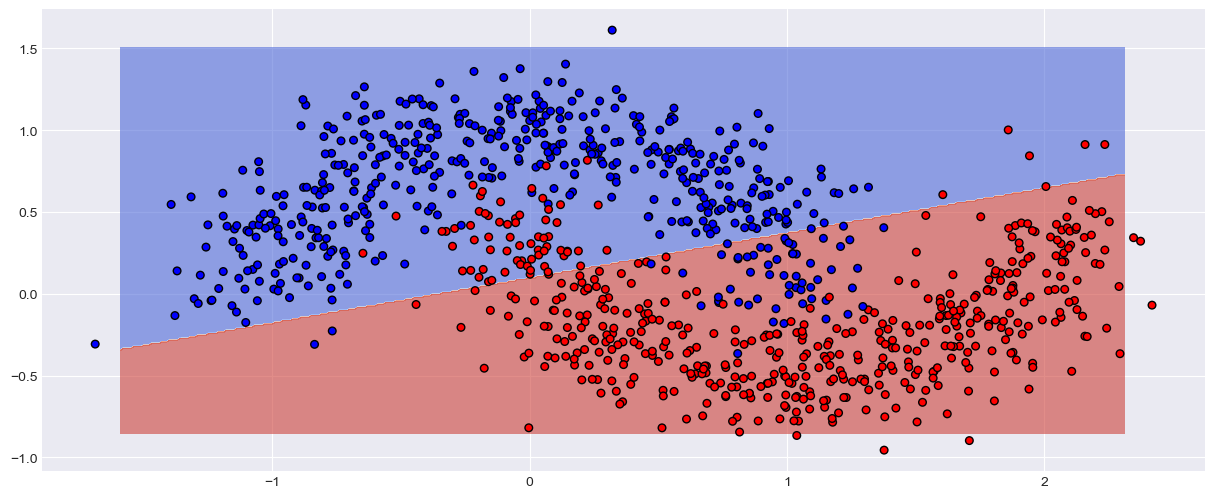

In [198]:
plot_decision_boundary()

## ASSIGNMENTS 1 & 2: EPOCHS, ALPHA 
#### Change them and see, intution on how things change when you change them
paste compare and make a note of the changes(not in submission just for you <3>)